In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn

csv = pd.read_csv("data.csv")
df = pd.DataFrame(csv)
df_time_offset = df["Timestamp"][0]
df["Timestamp"] = df["Timestamp"] - df_time_offset
df

,Timestamp,a_x,a_y,a_z,g_x,g_y,g_z
0,0.000000,0.006908,0.004879,-0.999282,-0.089739,-0.093836,-0.016821
1,0.009995,0.010393,0.007609,-0.995548,0.019353,-0.005159,0.061957
2,0.019989,0.009927,0.008011,-0.996089,0.054294,0.065126,0.045728
3,0.029999,0.009126,0.008241,-0.995904,0.001853,-0.021973,0.009278
4,0.039993,0.008407,0.006510,-0.996293,-0.035007,0.117921,-0.004276
...,...,...,...,...,...,...,...
4996,49.979996,0.006730,0.005675,-0.995030,-0.028298,0.059184,-0.021127
4997,49.990005,0.007908,0.005108,-0.993521,0.097276,-0.063120,0.009177
4998,49.999985,0.006980,0.005677,-0.993604,-0.028043,0.023748,0.012993
4999,50.009995,0.007133,0.005456,-0.994518,0.057604,-0.094273,-0.010476


[[0.0, 8.6, 0], [10.36, 21.08, 1], [21.96, 30.8, 2], [32.72, 41.24, 3], [43.88, 51.52, 4], [52.52, 58.64, 0]]


<AxesSubplot:xlabel='Timestamp', ylabel='Pose'>

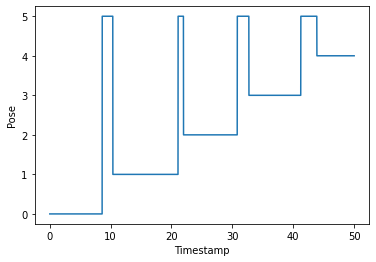

In [53]:
POSE_MAP= {
    "rett": 0,
    "framover": 1,
    "bakover": 2,
    "venstre": 3,
    "hoyre": 4
}

def get_timestamp_and_pose(filename):
    rows = []
    with open(filename, "r") as f:
        lines = f.readlines()
        offset = float(lines[1].strip().split(";")[1]) # This offset is the duration spent in the video before recording of data begun.
        for l in lines[1:]:
            sep_row = l.strip().split(";")
            finished_row = [round(float(x)-offset,2) for x in sep_row[1:3]]
            finished_row.append(POSE_MAP[sep_row[3].lower()])
            rows.append(finished_row)
    return rows
            

f_name = "../data/simon_data_2.txt"
stamped_poses = get_timestamp_and_pose(f_name)
print(stamped_poses)

df_stamped_poses = []
index = 0
for stamp in df["Timestamp"]:  
    pose_id = -1
    if stamp <= stamped_poses[-1][1]: 
        if stamp > stamped_poses[index][1]:
            index += 1
        pose_id = stamped_poses[index][2]
        # If timestamp is in new index, but haven't reached the starting time of this interval yet, set pose_id to default value 5.
        if stamp < stamped_poses[index][0]:
            pose_id = 5
    # If timestamp of the data point exceeds last timestamp recorded by the annotation, append default -1 value
    df_stamped_poses.append(pose_id)

#print(df_stamped_poses)

df["Pose"] = df_stamped_poses
#print(df[2400:2500][:])

#df['Pose'].hist(bins=4)
sns.lineplot(data=df, x="Timestamp", y='Pose')




In [54]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

X = df
y = df["Pose"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

pred = knn.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))


[[252   0   0   0   0   0]
 [  0 312   0   0   0   0]
 [  0   0 281   0   0   0]
 [  0   0   0 239   0   0]
 [  0   0   0   0 193   0]
 [  0   0   0   0   0 224]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       252
           1       1.00      1.00      1.00       312
           2       1.00      1.00      1.00       281
           3       1.00      1.00      1.00       239
           4       1.00      1.00      1.00       193
           5       1.00      1.00      1.00       224

    accuracy                           1.00      1501
   macro avg       1.00      1.00      1.00      1501
weighted avg       1.00      1.00      1.00      1501

